### Neural Machine Translation in the wild

In [1]:
import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
File ‘data.txt’ already there; not retrieving.



In [2]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/utils.py -nc

if not os.path.exists('./my_network.py'):
    print("network file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/my_network.py -nc

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import numpy as np

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer

### Main part
__Here comes the preprocessing.__

In [4]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [5]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [6]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05], random_state=random.seed(42))

In [7]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cuda', index=0)

In [10]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

### Model 1 - RNN Attention
__В данной модели в качестве энкодера выступает bidirectional GRU, в качестве декодера - однослойная GRU. Между энкодером и декодером добавлен механизм Attention. [(Архитектура attention взята отсюда)](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb)__

In [11]:
import my_network_RNN_Attention
Encoder = my_network_RNN_Attention.Encoder
Attention = my_network_RNN_Attention.Attention
Decoder = my_network_RNN_Attention.Decoder
Seq2Seq = my_network_RNN_Attention.Seq2Seq

In [12]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attention = Attention(HID_DIM, HID_DIM * 2)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attention)

model_rnn_attention = Seq2Seq(enc, dec, device).to(device)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [13]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model_rnn_attention.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9250, 256)
    (rnn): GRU(256, 512, dropout=0.5, bidirectional=True)
    (fc_out): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (att): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6736, 256)
    (rnn): GRU(1280, 512, dropout=0.5)
    (out): Linear(in_features=1792, out_features=6736, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
print(f'The model has {count_parameters(model_rnn_attention):,} trainable parameters')

The model has 22,603,344 trainable parameters


In [15]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model_rnn_attention.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

In [18]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = elapsed_time / 60
    return elapsed_mins, elapsed_time

In [19]:
train_history_RNN_Attention = []
valid_history_RNN_Attention = []
epoch_secs_history_RNN_Attention = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

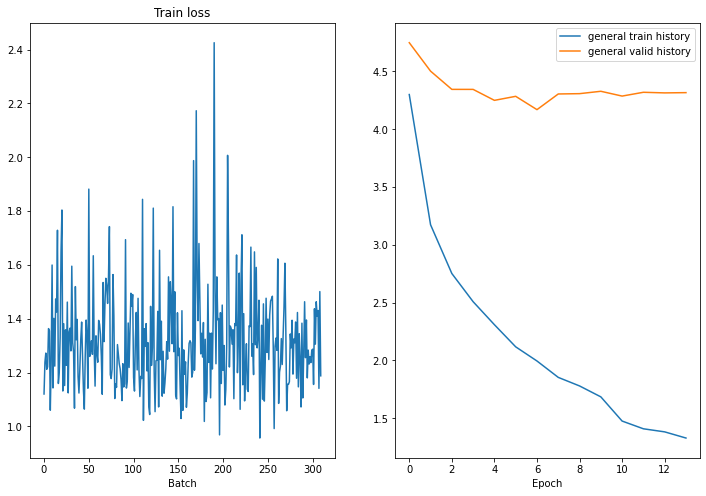

Epoch: 15 | Time: 4.695097875595093m 281.70587253570557s
	Train Loss: 1.319 | Train PPL:   3.739
	 Val. Loss: 4.331 |  Val. PPL:  76.007


In [20]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    train_loss = train(model_rnn_attention, train_iterator, optimizer, criterion, CLIP, train_history_RNN_Attention, valid_history_RNN_Attention)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    valid_loss = evaluate(model_rnn_attention, valid_iterator, criterion)
    scheduler.step(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_rnn_attention.state_dict(), 'tut-model-RNN_Attention.pt')
    
    train_history_RNN_Attention.append(train_loss)
    valid_history_RNN_Attention.append(valid_loss)
    epoch_secs_history_RNN_Attention.append(epoch_secs)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [21]:
# скорость обучения модели (с точки зрения затраченного времени)
average_epoch_secs_history_RNN_Attention = np.mean(epoch_secs_history_RNN_Attention)
print(f"Среднее время одной эпохи в секундах: {average_epoch_secs_history_RNN_Attention} seconds")
print(f"Среднее время одной эпохи в минутах: {average_epoch_secs_history_RNN_Attention / 60} minutes")

# количество пар использованных примеров (число эпох * число обработанных батчей за одну эпоху * размер батча) 
num_pairs_examples_used_RNN_Attention = N_EPOCHS * len(train_iterator) * BATCH_SIZE
print(f"Количество пар использованных примеров: {num_pairs_examples_used_RNN_Attention}")

Среднее время одной эпохи в секундах: 279.722017065684 seconds
Среднее время одной эпохи в минутах: 4.6620336177613995 minutes
Количество пар использованных примеров: 600960


__Let's take a look at our network quality__:

In [22]:
from nltk.translate.bleu_score import corpus_bleu

import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [23]:
original_text = []
generated_text = []
eval_secs_history_RNN_Attention = []
model_rnn_attention.eval()
with torch.no_grad():

    for i, batch in enumerate(test_iterator):

        src = batch.src
        trg = batch.trg
        
        start_time = time.time()
        output = model_rnn_attention(src, trg, 0) #turn off teacher forcing
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        eval_secs_history_RNN_Attention.append(epoch_secs)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

In [24]:
#  скорость применения модели в режиме inference в пересчете на один батч размером 32 (если размер батча необходимо уменьшить, например, до 16, то умножьте усредненный результат на 32/16 = 2)
eval_secs_history_RNN_Attention_32 = np.mean(eval_secs_history_RNN_Attention) * (32 / BATCH_SIZE)
print(f"Cкорость применения модели в режиме inference в пересчете на один батч размером 32: {eval_secs_history_RNN_Attention_32} seconds")

bleu_RNN_Attention = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(f"BLEU for this model: {bleu_RNN_Attention}")

Cкорость применения модели в режиме inference в пересчете на один батч размером 32: 0.018566556906296036 seconds
BLEU for this model: 34.05330028261969


__На самом деле, перевод получился довольно хороший, поэтому найти пример плохого перевода было достаточно сложно)__

In [33]:
def print_translation(original_text, generated_text):
    orig = " ".join(original_text)
    gen = " ".join(generated_text)
    print(f"Оригинальный текст: {orig}\nСгенерированный текст: {gen}\n")

In [27]:
print("Пример плохого перевода:")
print_translation(original_text[4340], generated_text[4340])
print_translation(original_text[6521], generated_text[6521])

print("Пример хорошего перевода:")
print_translation(original_text[555], generated_text[555])
print_translation(original_text[3458], generated_text[3458])

Пример плохого перевода:
Оригинальный текст: offers fully furnished apartments and studios located on boulevard along the coast .
Сгенерированный текст: is located on the of coast in the .

Оригинальный текст: if you feel like visiting the surroundings , is in 2 . 3 km and in 2 . 6 km .
Сгенерированный текст: the property is 2 . 3 km from ski lift and 2 . 6 km from ski lift .

Пример хорошего перевода:
Оригинальный текст: free private parking is provided .
Сгенерированный текст: private parking is available on site .

Оригинальный текст: the shops and restaurants of town centre are 1 km from the motel .
Сгенерированный текст: the town centre with its shops and restaurants , 1 km away from the motel .



### Model 2 - CNN Encoder
__В данной модели в качестве энкодера выступает сверточная нейронная сеть (CNN) с Positional Encoding, в качестве декодера - однослойная GRU.__ 

__В энкодере используется 3 сверточных слоя с различным размером ядра (2, 3, 4) + ReLu, которые применяются к закодированному инпуту, выходы сверток конкатенируются и к результату применяется AdaptiveMaxPooll для уменьшешения количества каналов и последующей подачи в декодер.__

In [28]:
import my_network_norm_CNN_Encoder
Encoder = my_network_norm_CNN_Encoder.Encoder
Decoder = my_network_norm_CNN_Encoder.Decoder
Seq2Seq = my_network_norm_CNN_Encoder.Seq2Seq

In [29]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model_cnn_encoder = Seq2Seq(enc, dec, device).to(device)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [30]:
model_cnn_encoder.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (embedding): Embedding(9250, 256)
    (cnn1): Conv1d(256, 512, kernel_size=(2,), stride=(1,))
    (cnn2): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
    (cnn3): Conv1d(256, 512, kernel_size=(4,), stride=(1,))
    (dropout): Dropout(p=0.2, inplace=False)
    (relu): ReLU()
    (pool): AdaptiveMaxPool1d(output_size=1)
  )
  (decoder): Decoder(
    (embedding): Embedding(6736, 256)
    (rnn): GRU(256, 512, dropout=0.2)
    (out): Linear(in_features=512, out_features=6736, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [31]:
print(f'The model has {count_parameters(model_cnn_encoder):,} trainable parameters')

The model has 9,911,888 trainable parameters


In [32]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model_cnn_encoder.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

In [33]:
train_history_CNN_Encoder = []
valid_history_CNN_Encoder = []
epoch_secs_history_CNN_Encoder = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

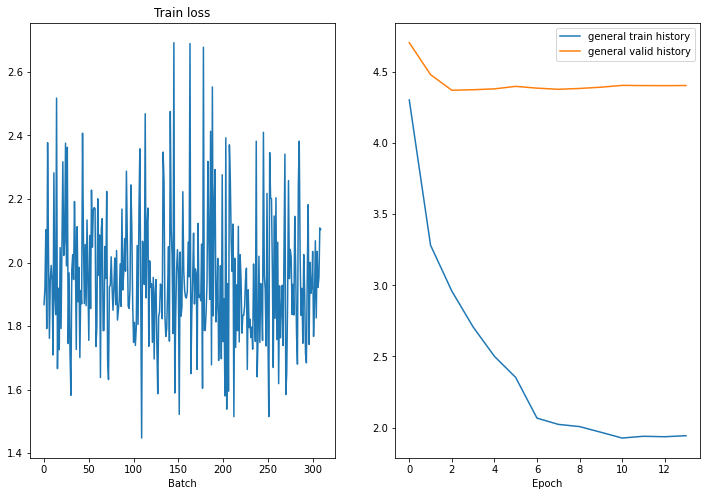

88.2609350681305
Epoch: 15 | Time: 1.4710155844688415m 88.2609350681305s
	Train Loss: 1.949 | Train PPL:   7.020
	 Val. Loss: 4.401 |  Val. PPL:  81.550


In [34]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    train_loss = train(model_cnn_encoder, train_iterator, optimizer, criterion, CLIP, train_history_CNN_Encoder, valid_history_CNN_Encoder)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(epoch_secs)
    
    valid_loss = evaluate(model_cnn_encoder, valid_iterator, criterion)
    scheduler.step(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_cnn_encoder.state_dict(), 'tut-model-CNN_Encoder.pt')
    
    train_history_CNN_Encoder.append(train_loss)
    valid_history_CNN_Encoder.append(valid_loss)
    epoch_secs_history_CNN_Encoder.append(epoch_secs)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [35]:
# скорость обучения модели (с точки зрения затраченного времени)
average_epoch_secs_history_CNN_Encoder = np.mean(epoch_secs_history_CNN_Encoder)
print(f"Среднее время одной эпохи в секундах: {average_epoch_secs_history_CNN_Encoder} seconds")
print(f"Среднее время одной эпохи в минутах: {average_epoch_secs_history_CNN_Encoder / 60} minutes")

# количество пар использованных примеров (число эпох * число обработанных батчей за одну эпоху * размер батча) 
num_pairs_examples_used_CNN_Encoder = N_EPOCHS * len(train_iterator) * BATCH_SIZE
print(f"Количество пар использованных примеров: {num_pairs_examples_used_CNN_Encoder}")

Среднее время одной эпохи в секундах: 88.66688899993896 seconds
Среднее время одной эпохи в минутах: 1.477781483332316 minutes
Количество пар использованных примеров: 600960


__Let's take a look at our network quality__:

In [36]:
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [37]:
original_text = []
generated_text = []
eval_secs_history_CNN_Encoder = []
model_cnn_encoder.eval()
with torch.no_grad():

    for i, batch in enumerate(test_iterator):

        src = batch.src
        trg = batch.trg
        
        start_time = time.time()
        output = model_cnn_encoder(src, trg, 0) #turn off teacher forcing
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        eval_secs_history_CNN_Encoder.append(epoch_secs)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

In [38]:
#  скорость применения модели в режиме inference в пересчете на один батч размером 32 (если размер батча необходимо уменьшить, например, до 16, то умножьте усредненный результат на 32/16 = 2)
eval_secs_history_CNN_Encoder_32 = np.mean(eval_secs_history_CNN_Encoder) * (32 / BATCH_SIZE)
print(f"Cкорость применения модели в режиме inference в пересчете на один батч размером 32: {eval_secs_history_CNN_Encoder_32} seconds")

bleu_CNN_Encoder = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(f"BLEU for this model: {bleu_CNN_Encoder}")

Cкорость применения модели в режиме inference в пересчете на один батч размером 32: 0.016071048833556093 seconds
BLEU for this model: 24.549164524279465


In [41]:
print("Пример плохого перевода:")
print_translation(original_text[4797], generated_text[4797])
print_translation(original_text[3240], generated_text[3240])

print("Пример хорошего перевода:")
print_translation(original_text[0], generated_text[0])
print_translation(original_text[65], generated_text[65])

Пример плохого перевода:
Оригинальный текст: everything kitzbühel has to offer is within easy walking distance from hotel zur .
Сгенерированный текст: all .

Оригинальный текст: market is just 100 metres away .
Сгенерированный текст: is only 100 metres away from the .

Пример хорошего перевода:
Оригинальный текст: the property offers free parking .
Сгенерированный текст: free parking is available .

Оригинальный текст: the bathrooms have a shower cabin .
Сгенерированный текст: the bathroom comes with a shower .



### Model 3 - Transformer
__В данной модели реализован transformer из статьи `Attention is all you need` с небольшой доработкой из [данного](https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb) ноутбука: в качестве positional encoding обучен `nn.Embedding` слой, потому что vanilla positional encoding через синусы и косинусы дал не лучший результат. В качестве энкодера и декодера выступает `nn.TransformerEncoder` и `nn.TransformerDecoder`.__


In [42]:
import my_network_norm_Transformer
Encoder = my_network_norm_Transformer.Encoder
Decoder = my_network_norm_Transformer.Decoder
Seq2Seq = my_network_norm_Transformer.Seq2Seq

In [43]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 512
N_HEAD = 8
NUM_LAYERS = 3
DIM_FEEDFORWARD = 2048
DROPOUT = 0.1

encoder = Encoder(
    src_input_dim=INPUT_DIM, 
    d_model=HID_DIM, 
    nhead=N_HEAD, 
    num_encoder_layers=NUM_LAYERS, 
    dim_feedforward=DIM_FEEDFORWARD, 
    dropout=DROPOUT, 
    device=device,
    src_pad_index=SRC.vocab.stoi["<pad>"],
)
decoder = Decoder(
    trg_input_dim=OUTPUT_DIM,
    output_dim=OUTPUT_DIM,
    d_model=HID_DIM,
    nhead=N_HEAD, 
    num_decoder_layers=NUM_LAYERS, 
    dim_feedforward=DIM_FEEDFORWARD, 
    dropout=DROPOUT, 
    device=device,
    src_pad_index=SRC.vocab.stoi["<pad>"],
    trg_pad_index=TRG.vocab.stoi["<pad>"],
)
model_transformer = Seq2Seq(encoder, decoder).to(device)

In [44]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model_transformer.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (src_embedding): Embedding(9250, 512)
    (src_pos_encoder): Embedding(100, 512)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
  

In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_transformer):,} trainable parameters')

The model has 33,814,096 trainable parameters


In [46]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model_transformer.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

In [47]:
def train_transformer(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg[:-1, :])
        
        # trg = [trg sent len, batch size]
        # output = [trg sent len, batch size, output dim]

        output = output.contiguous().view(-1, output.shape[-1])
        trg = trg[1:, :].contiguous().view(-1)
        
        # trg = [(trg sent len - 1) * batch size]
        # output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i + 1) % 10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [48]:
def evaluate_transformer(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg[:-1, :]) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.view(-1, output.shape[-1])
            trg = trg[1:, :].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [49]:
train_history_transformer = []
valid_history_transformer = []
epoch_secs_history_transformer = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

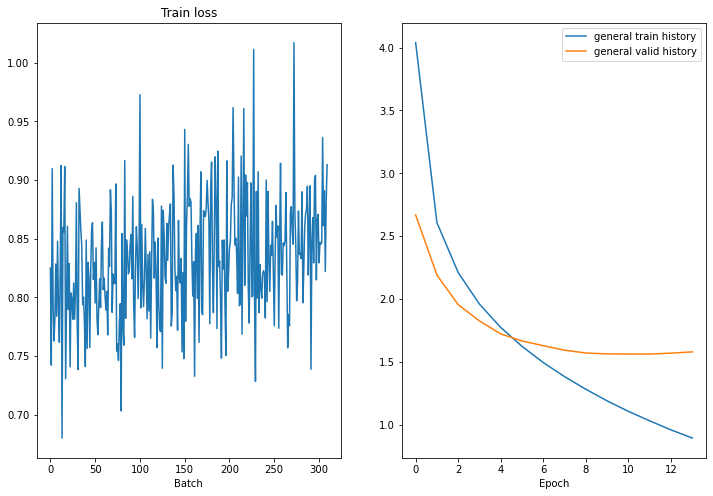

Epoch: 15 | Time: 1.9132716139157613m 114.79629683494568s
	Train Loss: 0.833 | Train PPL:   2.300
	 Val. Loss: 1.592 |  Val. PPL:   4.916


In [50]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    train_loss = train_transformer(model_transformer, train_iterator, optimizer, criterion, CLIP, train_history_transformer, valid_history_transformer)
    end_time = time.time()
    valid_loss = evaluate_transformer(model_transformer, valid_iterator, criterion)
    scheduler.step(valid_loss)
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_transformer.state_dict(), f'tut-model_transformer.pt')
    
    train_history_transformer.append(train_loss)
    valid_history_transformer.append(valid_loss)
    epoch_secs_history_transformer.append(epoch_secs)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [51]:
# скорость обучения модели (с точки зрения затраченного времени)
average_epoch_secs_history_transformer = np.mean(epoch_secs_history_transformer)
print(f"Среднее время одной эпохи в секундах: {average_epoch_secs_history_transformer} seconds")
print(f"Среднее время одной эпохи в минутах: {average_epoch_secs_history_transformer / 60} minutes")

# количество пар использованных примеров (число эпох * число обработанных батчей за одну эпоху * размер батча) 
num_pairs_examples_used_transformer = N_EPOCHS * len(train_iterator) * BATCH_SIZE
print(f"Количество пар использованных примеров: {num_pairs_examples_used_transformer}")

Среднее время одной эпохи в секундах: 114.25503374735514 seconds
Среднее время одной эпохи в минутах: 1.904250562455919 minutes
Количество пар использованных примеров: 600960


__Let's take a look at our network quality__:

In [52]:
from nltk.translate.bleu_score import corpus_bleu

import utils
import imp

imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [53]:
def translate_sentence(model, sentence, src_vocab, trg_vocab, device, max_len=100):
    model.eval()
    with torch.no_grad():
        
        src_enc = model.encoder(sentence)
        # src_enc = [src_len, 1, hid_dim]
        
        trg = [trg_vocab.stoi["<sos>"]]
        
        for _ in range(max_len):
            output = model.decoder(
                sentence, 
                src_enc, 
                torch.tensor(trg).unsqueeze(1).to(device),
            )
            # output = [tgt len, 1, tgt_vocab]
            output_idx = output.argmax(dim=-1)[-1, :].item()
            
            trg.append(output_idx)
            if output_idx == trg_vocab.stoi["<eos>"]:
                break
            
        return trg[1:]

In [54]:
original_text = []
generated_text = []
eval_secs_history_transformer = []
model_transformer.eval()
with torch.no_grad():

    for i, batch in enumerate(test_iterator):

        batch_src = batch.src.permute(1, 0)
        batch_trg = batch.trg.permute(1, 0)
        
        for src, trg in zip(batch_src, batch_trg):
            src = src.unsqueeze(1)
            trg = trg.unsqueeze(1)
            
            start_time = time.time()
            output = translate_sentence(model_transformer, src, SRC.vocab, TRG.vocab, device)
            end_time = time.time()
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)
            eval_secs_history_transformer.append(epoch_secs)

            original_text.extend([get_text(x, TRG.vocab) for x in trg[1:, :].cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in np.array([output])])

В данном случае размер батча равен 1

In [55]:
# скорость применения модели в режиме inference в пересчете на один батч размером 32 (если размер батча необходимо уменьшить, например, до 16, то умножьте усредненный результат на 32/16 = 2)
eval_secs_history_transformer_32 = np.mean(eval_secs_history_transformer) * (32 / 1)
print(f"Cкорость применения модели в режиме inference в пересчете на один батч размером 32: {eval_secs_history_transformer_32} seconds")

bleu_transformer = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(f"BLEU for this model: {bleu_transformer}")

Cкорость применения модели в режиме inference в пересчете на один батч размером 32: 2.083731115722656 seconds
BLEU for this model: 32.16712358178473


In [57]:
def print_translation(original_text, generated_text):
    orig = " ".join(original_text)
    gen = " ".join(generated_text)
    print(f"Оригинальный текст: {orig}\nСгенерированный текст: {gen}\n")
    
print("Пример плохого перевода:")
print_translation(original_text[4752], generated_text[4752])
print_translation(original_text[4548], generated_text[4548])

print("Пример хорошего перевода:")
print_translation(original_text[2092], generated_text[2092])
print_translation(original_text[5035], generated_text[5035])

Пример плохого перевода:
Оригинальный текст: in addition , b & b offers a free safari .
Сгенерированный текст: bed & breakfast offers on a safari .

Оригинальный текст: you can play mini golf or visit the games room , with billiards and table tennis .
Сгенерированный текст: you can play mini golf and billiards at the mini - golf or table tennis .

Пример хорошего перевода:
Оригинальный текст: the bathroom includes a bath or a shower .
Сгенерированный текст: each room comes with a bathroom fitted with a bath or shower .

Оригинальный текст: each room here will provide guests with a cable led tv , air conditioning and a minibar .
Сгенерированный текст: each room is equipped with a cable tv , air conditioning and a minibar .



### Model 4 - ruBERT Encoder
__В данной модели в качестве энкодера выступает ruBERT [(спасибо Hugging Face и DeepPavlov)](https://huggingface.co/DeepPavlov/rubert-base-cased-sentence), в качестве декодера - GRU. Между энкодером и декодером реализован механизм Attention. RuBert был заморожен и не обучался.__ 

RuBERT требует немного другой препроцессинг данных, поэтому препроцессинг был осуществлен с нуля.

In [5]:
from transformers import AutoTokenizer, AutoModel
  
tokenizer_ru_bert = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

model_ru_bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

In [6]:
def ru_tokenize(x, tokenizer=tokenizer_ru_bert):
    return tokenizer.tokenize(x.lower())

tokenizer_W = WordPunctTokenizer()
def en_tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [7]:
SRC = Field(tokenize=ru_tokenize,
            init_token='[CLS]',
            eos_token='[SEP]',
            pad_token='[PAD]',
            unk_token='[UNK]',)

TRG = Field(tokenize=en_tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [8]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05], random_state=random.seed(42))

In [9]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [10]:
SRC.vocab.stoi = tokenizer_ru_bert.get_vocab()
SRC.vocab.itos = {v: k for k, v in tokenizer_ru_bert.get_vocab().items()}

In [11]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [12]:
import my_network_ruBERT_Attention
Encoder = my_network_ruBERT_Attention.Encoder
Attention = my_network_ruBERT_Attention.Attention
Decoder = my_network_ruBERT_Attention.Decoder
Seq2Seq = my_network_ruBERT_Attention.Seq2Seq

In [13]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 768
N_LAYERS = 1
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(model_ru_bert, SRC.vocab, device)
attention = Attention(HID_DIM, HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attention)

# dont forget to put the model to the right device
model_ru_bert = Seq2Seq(enc, dec, device).to(device)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model_ru_bert.decoder.apply(init_weights)

Decoder(
  (attention): Attention(
    (att): Linear(in_features=1536, out_features=768, bias=True)
    (v): Linear(in_features=768, out_features=1, bias=False)
  )
  (embedding): Embedding(6736, 256)
  (rnn): GRU(1024, 768, dropout=0.2)
  (out): Linear(in_features=1792, out_features=6736, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [15]:
# заморозим веса ruBERT
for param in model_ru_bert.encoder.parameters():
    param.requires_grad = False

In [21]:
print(f'The model has {count_parameters(model_ru_bert):,} trainable parameters')

The model has 19,116,624 trainable parameters


In [22]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model_ru_bert.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

In [23]:
train_history_ru_bert = []
valid_history_ru_bert = []
epoch_secs_history_ru_bert = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

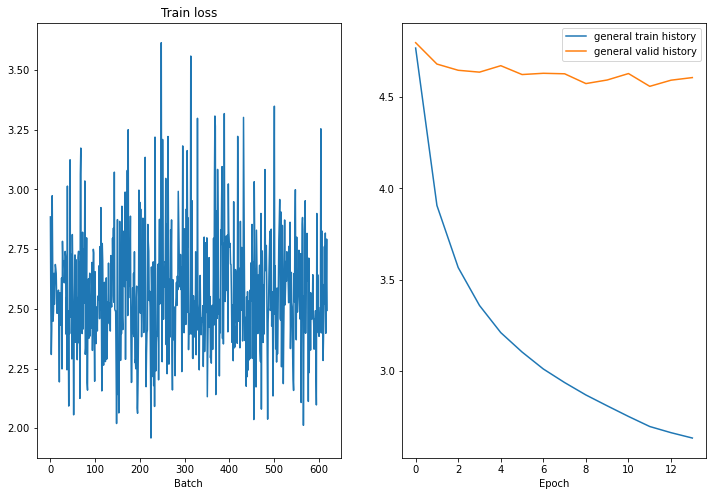

Epoch: 15 | Time: 8.29867228269577m 497.9203369617462s
	Train Loss: 2.566 | Train PPL:  13.012
	 Val. Loss: 4.615 |  Val. PPL: 100.940


In [24]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    train_loss = train(model_ru_bert, train_iterator, optimizer, criterion, CLIP, train_history_ru_bert, valid_history_ru_bert)
    end_time = time.time()
    valid_loss = evaluate(model_ru_bert, valid_iterator, criterion)
    scheduler.step(valid_loss)
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_ru_bert.state_dict(), 'tut-model_ru_bert.pt')
    
    train_history_ru_bert.append(train_loss)
    valid_history_ru_bert.append(valid_loss)
    epoch_secs_history_ru_bert.append(epoch_secs)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [25]:
# скорость обучения модели (с точки зрения затраченного времени)
average_epoch_secs_history_ru_bert = np.mean(epoch_secs_history_ru_bert)
print(f"Среднее время одной эпохи в секундах: {average_epoch_secs_history_ru_bert} seconds")
print(f"Среднее время одной эпохи в минутах: {average_epoch_secs_history_ru_bert / 60} minutes")

# количество пар использованных примеров (число эпох * число обработанных батчей за одну эпоху * размер батча) 
num_pairs_examples_used_ru_bert = N_EPOCHS * len(train_iterator) * BATCH_SIZE
print(f"Количество пар использованных примеров: {num_pairs_examples_used_ru_bert}")

Среднее время одной эпохи в секундах: 494.2936296621958 seconds
Среднее время одной эпохи в минутах: 8.238227161036598 minutes
Количество пар использованных примеров: 600000


__Let's take a look at our network quality__:

In [27]:
from nltk.translate.bleu_score import corpus_bleu

import utils
import imp

In [28]:
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [29]:
original_text = []
generated_text = []
eval_secs_history_ru_bert = []
model_ru_bert.eval()
with torch.no_grad():

    for i, batch in enumerate(test_iterator):

        src = batch.src
        trg = batch.trg
        
        start_time = time.time()
        output = model_ru_bert(src, trg, 0) #turn off teacher forcing
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        eval_secs_history_ru_bert.append(epoch_secs)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

In [30]:
# скорость применения модели в режиме inference в пересчете на один батч размером 32 (если размер батча необходимо уменьшить, например, до 16, то умножьте усредненный результат на 32/16 = 2)
eval_secs_history_ru_bert_32 = np.mean(eval_secs_history_ru_bert) * (32 / BATCH_SIZE)
print(f"Cкорость применения модели в режиме inference в пересчете на один батч размером 32: {eval_secs_history_ru_bert_32} seconds")

bleu_ru_bert = corpus_bleu([[text] for text in original_text], generated_text) * 100
print(f"BLEU for this model: {bleu_ru_bert}")

Cкорость применения модели в режиме inference в пересчете на один батч размером 32: 0.026778048377926068 seconds
BLEU for this model: 15.994632331043878


In [35]:
print("Пример плохого перевода:")
print_translation(original_text[1913], generated_text[1913])
print_translation(original_text[4970], generated_text[4970])

print("Пример хорошего перевода:")
print_translation(original_text[3], generated_text[3])

Пример плохого перевода:
Оригинальный текст: if you feel like visiting the surroundings , check out pula golf 2 . 4 km from the property .
Сгенерированный текст: the golf golf course is 2 . 4 km from the golf club , 2 . 4 km from the golf

Оригинальный текст: beach is 30 km and porto beach is at a distance of 35 km .
Сгенерированный текст: the property is 30 km from the sandy beach , 35 km from punta beach , 35 km from the property .

Пример хорошего перевода:
Оригинальный текст: free wi - fi is included .
Сгенерированный текст: free wi - fi access is available in the property .



В сгенерированном переводе слова часто повторяются

# Final results

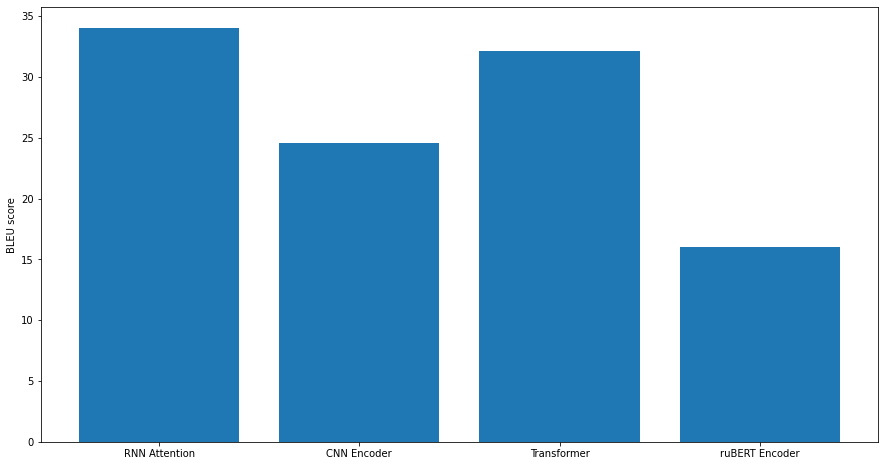

In [38]:
fig, ax = plt.subplots()

ax.bar([1, 2, 3, 4],
       [
           bleu_RNN_Attention,
           bleu_CNN_Encoder,
           bleu_transformer,
           bleu_ru_bert,
       ],
       tick_label=[
           "RNN Attention",
           "CNN Encoder",
           "Transformer",
           "ruBERT Encoder"
       ]
    )

fig.set_figwidth(15)
fig.set_figheight(8) 
ax.set_ylabel("BLEU score")
plt.show()

In [39]:
import pandas as pd

In [185]:
d = {
    "№ experiment": [1, 2, 3, 4],
    "encoder": ["bidirectional GRU", "CNN", "transformer encoder", "ruBERT"],
    "decoder": ["GRU", "LSTM", "transformer decoder", "GRU"],
    "attention": ["+", "-", "+", "+"],
    "скорость обучения (одна эпоха) в секундах": [
        average_epoch_secs_history_RNN_Attention,
        average_epoch_secs_history_CNN_Encoder,
        average_epoch_secs_history_transformer,
        average_epoch_secs_history_ru_bert,
    ],
    "количество пар использованных примеров": [
        num_pairs_examples_used_RNN_Attention,
        num_pairs_examples_used_CNN_Encoder,
        num_pairs_examples_used_transformer,
        num_pairs_examples_used_ru_bert,
    ],
    "скорость применения модели в режиме inference в пересчете на один батч размером 32": [
        eval_secs_history_RNN_Attention_32,
        eval_secs_history_CNN_Encoder_32,
        eval_secs_history_transformer_32,
        eval_secs_history_ru_bert_32,
    ],
    "BLEU": [
        bleu_RNN_Attention,
        bleu_CNN_Encoder,
        bleu_transformer,
        bleu_ru_bert,
    ],
}
df = pd.DataFrame(data=d)

In [41]:
df

,№ experiment,encoder,decoder,attention,скорость обучения (одна эпоха) в секундах,количество пар использованных примеров,скорость применения модели в режиме inference в пересчете на один батч размером 32,BLEU
0,1,bidirectional GRU,GRU,+,279.722017,600960,0.018567,34.053300
1,2,CNN,LSTM,-,88.666889,600960,0.016071,24.549165
2,3,transformer encoder,transformer decoder,+,114.255034,600960,2.083731,32.167124
3,4,ruBERT,GRU,+,494.293630,600000,0.026778,15.994632


__В итоге, лучшие результаты с точки зрения BLEU показали архитетктуры 1 и 3 (GRU with attention и transformer). Быстрее всех обучалась архитектура 2 (CNN Encoder). К удивлению RuBert показал далеко не лучший результат, хотя возможно стоило более тщательней крутить гиперпараметры модели. Также стоит отметить, что функция инференса для трансформера была написана не совсем оптимально с точки зрения времени, поэтому скорость применения модели в режиме инференса такая медленная.__